# 1. Predicting Gender of Brazilian Names Using Deep Learning


## 1.1 Necessary libraries

In [1]:
!pip install tensorflow

In [2]:
import tensorflow

In [37]:
import pandas as pd                       
import numpy as np
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, GRU, SimpleRNN, LSTM, Bidirectional, Activation, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt


## 1.2 Read the dataset

In [38]:
df =pd.read_excel(r"C:\Users\Jebbar Abdelkader\Desktop\fiabilisation_28_01_2022\Gender Classification With  Machine Learning\training.xlsx")
df.head()

,name,sex
0,Mary,F
1,Anna,F
2,Emma,F
3,Elizabeth,F
4,Minnie,F


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96438 entries, 0 to 96437
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    96438 non-null  object
 1   sex     96438 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


### 1.2.1 Preparing the data 

In [40]:
y = df['sex'].astype("category").cat.codes.values    # y labels into numbers 0 is F and 1 is M
names = df['name'].apply(lambda x: x.lower())             # input names

In [41]:

print("M : " + str(sum(y==1)))
print("F : " + str(sum(y==0)))
print(len(y))

M : 35097
F : 61224
96438


## 1.3 Encoding Words

Neural networks can only learn to find patterns in numerical data, so it is necessary to convert our data into numeric values with word encoding or tokenization. 

In [42]:
#word encoding
maxlen = 20                                               # max lenght of a name
'''Define a vocabulary which corresponds to all the unique letters encountered'''
vocab = set(' '.join([str(i) for i in names]))            # creating a vocab
vocab.add('END')
len_vocab = len(vocab)
''' The dictionary maps each letter of vocabulary to a number '''
char_index = dict((c, i) for i, c in enumerate(vocab))    # creating a dictionary

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    aux = np.zeros(len_vocab);
    aux[i] = 1
    return list(aux)

# Truncate names and create the matrix
def prepare_encod_names(X):
    vec_names = []
    trunc_name = [str(i)[0:maxlen] for i in X]  # consider only the first 20 characters
    for i in trunc_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        vec_names.append(tmp)
    return vec_names

In [43]:
names.values

array(['mary', 'anna', 'emma', ..., 'papeterie ', 'librairie', 'jdfhj'],
      dtype=object)

In [44]:
x = prepare_encod_names(names.values)   # Now the names are encod as a vector of numbers 

## 1.4 Split the data into test and train

In [45]:
# train, val, test set will be 60%, 20%, 20% of the dataset respectively
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

## 1.5 Building the CNN Model

In [11]:
CNNmodel = keras.Sequential()  
CNNmodel.add(Conv1D(32, 2, activation='relu', input_shape=(20,28) )) # 32 convolution filters used each of size 2
CNNmodel.add(Conv1D(64, 3, activation='relu' ))       # 64 convolution filters used each of size 3
CNNmodel.add(MaxPooling1D(pool_size=(1,)))            # choose the best features via pooling
CNNmodel.add(Dropout(0.25))                           # randomly turn neurons on and off to improve convergence
CNNmodel.add(Flatten())                               # flatten we only want a classification output
CNNmodel.add(Dense(150, activation='relu'))           # fully connected to get all relevant data
CNNmodel.add(Dropout(0.1))                            # one more dropout
CNNmodel.add(Dense(1, activation='sigmoid'))          # output 

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adagrad(learning_rate=lr_schedule)
CNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
validation_data=(x_val, y_val)
#CNNhistory = CNNmodel.fit(x_train, y_train, validation_data,  epochs=20, batch_size=128) # Getting score metrics
#scores = CNNmodel.evaluate(x_test, y_test) 
#print("Accuracy: %.2f%%" % (scores[1]*100))

## 1.6 Building the RNN Model

In [12]:
RNNmodel=keras.Sequential()
RNNmodel.add(SimpleRNN(32, input_shape=(x_train.shape[1],x_train.shape[2]), activation='tanh', return_sequences=True))
RNNmodel.add(TimeDistributed(Dense(1))) 
RNNmodel.add(Flatten())
RNNmodel.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
RNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

RNNhistory=RNNmodel.fit(x_train, y_train , epochs=20, batch_size=128, validation_data=(x_val,y_val))
RNNscores = RNNmodel.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (RNNscores[1]*100))

Epoch 1/20
483/483 [==============================] - 4s 8ms/step - loss: 0.4267 - accuracy: 0.7986 - val_loss: 0.3785 - val_accuracy: 0.8296
Epoch 2/20
483/483 [==============================] - 3s 7ms/step - loss: 0.3596 - accuracy: 0.8384 - val_loss: 0.3542 - val_accuracy: 0.8409
Epoch 3/20
483/483 [==============================] - 4s 7ms/step - loss: 0.3485 - accuracy: 0.8430 - val_loss: 0.3478 - val_accuracy: 0.8465
Epoch 4/20
483/483 [==============================] - 3s 7ms/step - loss: 0.3371 - accuracy: 0.8493 - val_loss: 0.3474 - val_accuracy: 0.8453
Epoch 5/20
483/483 [==============================] - 4s 8ms/step - loss: 0.3316 - accuracy: 0.8513 - val_loss: 0.3442 - val_accuracy: 0.8461
Epoch 6/20
483/483 [==============================] - 3s 7ms/step - loss: 0.3256 - accuracy: 0.8528 - val_loss: 0.3617 - val_accuracy: 0.8409
Epoch 7/20
483/483 [==============================] - 4s 9ms/step - loss: 0.3230 - accuracy: 0.8550 - val_loss: 0.3489 - val_accuracy: 0.8452
Epoch 

In [30]:
def genderpredictor2(a):
    testename = prepare_encod_names({a})   # Now the names are encod as a vector of numbers with weight
    re=(RNNmodel.predict(testename) > 0.5).astype("int32")
    if int(re)==1:
        return "Male"
    else:
        return "Female"
female=pd.read_excel(r"C:\Users\Jebbar Abdelkader\Desktop\ListeFE.xlsx")
female['genre']=female['name'].apply(lambda x:genderpredictor2(x))

KeyError: 'A'

## 1.7 Building the GRU Model

In [13]:
GRUmodel=keras.Sequential()
GRUmodel.add(GRU(32, input_shape=(x_train.shape[1],x_train.shape[2]),activation='tanh', return_sequences=True))
GRUmodel.add(TimeDistributed(Dense(1))) 
GRUmodel.add(Flatten())
GRUmodel.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
GRUmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

GRUhistory=GRUmodel.fit(x_train, y_train , epochs=20, batch_size=128, validation_data=(x_val,y_val))
GRUscores = GRUmodel.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (GRUscores[1]*100))  

Epoch 1/20
483/483 [==============================] - 10s 18ms/step - loss: 0.3964 - accuracy: 0.8164 - val_loss: 0.3532 - val_accuracy: 0.8441
Epoch 2/20
483/483 [==============================] - 8s 17ms/step - loss: 0.3270 - accuracy: 0.8542 - val_loss: 0.3113 - val_accuracy: 0.8612
Epoch 3/20
483/483 [==============================] - 8s 16ms/step - loss: 0.2960 - accuracy: 0.8662 - val_loss: 0.2906 - val_accuracy: 0.8693
Epoch 4/20
483/483 [==============================] - 8s 16ms/step - loss: 0.2685 - accuracy: 0.8744 - val_loss: 0.2894 - val_accuracy: 0.8723
Epoch 5/20
483/483 [==============================] - 8s 17ms/step - loss: 0.2535 - accuracy: 0.8777 - val_loss: 0.2947 - val_accuracy: 0.8668
Epoch 6/20
483/483 [==============================] - 7s 15ms/step - loss: 0.2276 - accuracy: 0.8775 - val_loss: 0.2359 - val_accuracy: 0.8707
Epoch 7/20
483/483 [==============================] - 8s 17ms/step - loss: 0.3361 - accuracy: 0.8524 - val_loss: 0.3020 - val_accuracy: 0.855

In [28]:
def genderpredictor1(a):
    testename = prepare_encod_names({a})   # Now the names are encod as a vector of numbers with weight
    res=(GRUmodel.predict(testename) > 0.8).astype("int32")
    if int(res)==1:
        return "Male"
    else:
        return "Female"
female=pd.read_excel(r"C:\Users\Jebbar Abdelkader\Desktop\ListeFE.xlsx")
female['genre']=female['name'].apply(lambda x:genderpredictor1(x))

KeyError: 'A'

## 1.8 Building the DNN Model

In [16]:
DNNmodel = keras.Sequential()                                   # Sequential model
n_inputs = 28                                                   # nº of states  
inputs = keras.Input(shape=(20,n_inputs,), name = 'input')      # Define inputs
l1=layers.Dense(64, activation='relu', name = 'hidden_layer_1')(inputs) 
ly2=layers.Dense(128, activation='softplus', name = 'hidden_layer_2')(l1) 
l3=layers.Dropout(0.25)(ly2)
l4=layers.Flatten()(l3)                 
output=[] 
output.append(layers.Dense(1, activation='sigmoid', name = 'output')(l4))                                    
DNNmodel = keras.Model(inputs=inputs, outputs=output)       

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
DNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

#DNNhistory = DNNmodel.fit(x_train, y_train, batch_size=32, epochs=20, validation_data =(x_val, y_val))
#DNNscores = DNNmodel.evaluate(x_test, y_test) 
#print("Accuracy: %.2f%%" % (DNNscores[1]*100))

## 1.9 Building the BiLSTM Model

In [18]:
LSTMmodel = keras.Sequential()
LSTMmodel.add(
    Bidirectional(LSTM(64, return_sequences=True),
                  backward_layer=LSTM(64,
                                      return_sequences=True,
                                      go_backwards=True),
                  input_shape=(maxlen, len_vocab)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Bidirectional(LSTM(64)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Dense(1, activity_regularizer=l2(0.002)))
LSTMmodel.add(Activation('sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2, decay_steps=10000, decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
LSTMmodel.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

LSTMhistory = LSTMmodel.fit(x_train,
                            y_train,
                            batch_size=128,
                            epochs=20,
                            validation_data=(x_val, y_val))
LSTMscores = LSTMmodel.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (LSTMscores[1] * 100))

Epoch 1/20
483/483 [==============================] - 72s 143ms/step - loss: 0.4145 - accuracy: 0.8131 - val_loss: 0.3549 - val_accuracy: 0.8483
Epoch 2/20
483/483 [==============================] - 60s 124ms/step - loss: 0.3473 - accuracy: 0.8537 - val_loss: 0.3264 - val_accuracy: 0.8629
Epoch 3/20
483/483 [==============================] - 67s 138ms/step - loss: 0.3116 - accuracy: 0.8709 - val_loss: 0.3010 - val_accuracy: 0.8768
Epoch 4/20
483/483 [==============================] - 67s 138ms/step - loss: 0.2811 - accuracy: 0.8823 - val_loss: 0.2885 - val_accuracy: 0.8797
Epoch 5/20
483/483 [==============================] - 68s 141ms/step - loss: 0.2552 - accuracy: 0.8916 - val_loss: 0.2759 - val_accuracy: 0.8803
Epoch 6/20
483/483 [==============================] - 68s 141ms/step - loss: 0.2371 - accuracy: 0.8957 - val_loss: 0.2508 - val_accuracy: 0.8898
Epoch 7/20
483/483 [==============================] - 72s 149ms/step - loss: 0.2083 - accuracy: 0.8997 - val_loss: 0.2510 - val_ac

## 1.10 Figures

<Figure size 432x288 with 0 Axes>

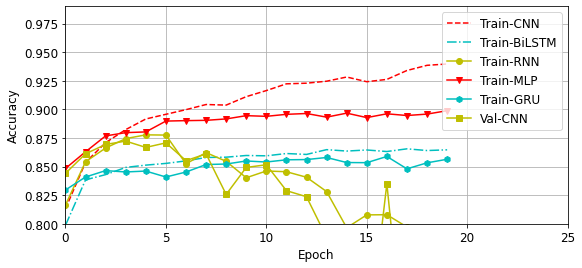

In [19]:
plt.figure(1)
plt.figure(figsize=(9,4))
plt.rcParams.update({'font.size': 12})
# summarize for accuracy
#plt.plot(CNNhistory.history['accuracy'], 'g:')
plt.plot(LSTMhistory.history['accuracy'], 'r--')
plt.plot(RNNhistory.history['accuracy'], 'c-.')
#plt.plot(DNNhistory.history['accuracy'], 'm-+')
plt.plot(GRUhistory.history['accuracy'], 'y-o')
#plt.plot(CNNhistory.history['val_accuracy'], 'g-*')
plt.plot(LSTMhistory.history['val_accuracy'], 'r-v')
plt.plot(RNNhistory.history['val_accuracy'], 'c-h')
#plt.plot(DNNhistory.history['val_accuracy'], 'm->')
plt.plot(GRUhistory.history['val_accuracy'], 'y-s')
plt.grid('True')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.8, 0.99)
plt.xlim(0,25)
plt.legend(['Train-CNN', 'Train-BiLSTM', 'Train-RNN', 'Train-MLP', 'Train-GRU','Val-CNN',\
            'Val-BiLSTM', 'Val-RNN', 'Val-MLP', 'Val-GRU'], loc='upper right')

(0.0, 32.0)

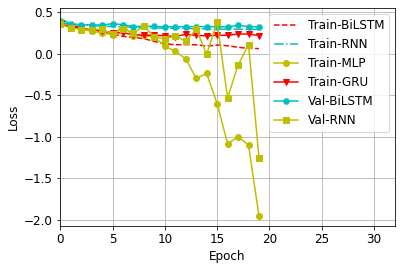

In [20]:
plt.figure(2)
#plt.plot(CNNhistory.history['loss'], 'g:')
plt.plot(LSTMhistory.history['loss'], 'r--')
plt.plot(RNNhistory.history['loss'], 'c-.')
#plt.plot(DNNhistory.history['loss'], 'm-+')
plt.plot(GRUhistory.history['loss'], 'y-o')
#plt.plot(CNNhistory.history['val_loss'], 'g-*')
plt.plot(LSTMhistory.history['val_loss'], 'r-v')
plt.plot(RNNhistory.history['val_loss'], 'c-H')
#plt.plot(DNNhistory.history['val_loss'], 'm->')
plt.plot(GRUhistory.history['val_loss'], 'y-s')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train-BiLSTM', 'Train-RNN', 'Train-MLP', 'Train-GRU',\
            'Val-BiLSTM', 'Val-RNN', 'Val-MLP', 'Val-GRU'], loc='upper right')
plt.grid('True')
plt.xlim(0,32)

## 1.11 Statistics

In [21]:
#y_predCNN =(CNNmodel.predict(x_test) > 0.5).astype("int32")
#y_predLSTM =(LSTMmodel.predict(x_test) > 0.5).astype("int32")
#y_predRNN =(RNNmodel.predict(x_test) > 0.5).astype("int32")
#y_predGRU =(GRUmodel.predict(x_test) > 0.5).astype("int32")
#y_predDNN =(DNNmodel.predict(x_test) > 0.5).astype("int32")

In [22]:
# Finding precision and recall
from sklearn.metrics import precision_score, recall_score
#print(precision_score(y_test, y_predLSTM))
#print(recall_score(y_test, y_predLSTM))

#print(precision_score(y_test, y_predRNN))
#print(recall_score(y_test, y_predRNN))

#print(precision_score(y_test, y_predCNN))
#print(recall_score(y_test, y_predCNN))

#print(precision_score(y_test, y_predGRU))
#print(recall_score(y_test, y_predGRU))

#print(precision_score(y_test, y_predDNN))
#print(recall_score(y_test, y_predDNN))

## 1.12 Testing 

In [23]:
testename = prepare_encod_names({"azi"})   # Now the names are encod as a vector of numbers with weight
resu=(LSTMmodel.predict(testename) > 0.5).astype("int32")
if int(resu)==1:
    print('M')
elif int(resu)==0:
    print('F')
else:
    print('N')

M


In [57]:

testename = prepare_encod_names('abla')   # Now the names are encod as a vector of numbers with weight
resu=(LSTMmodel.predict(testename) > 0.5).astype("int32")
if int(resu)==1:
    print("Male")   
else:
    print ("Female")
       



ValueError: in user code:

    File "C:\Users\Jebbar Abdelkader\anaconda3\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Jebbar Abdelkader\anaconda3\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Jebbar Abdelkader\anaconda3\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Jebbar Abdelkader\anaconda3\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\Jebbar Abdelkader\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Jebbar Abdelkader\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 30, 45), found shape=(None, 20, 45)


In [46]:
female=pd.read_excel(r"C:\Users\Jebbar Abdelkader\Desktop\ListeFE.xlsx")

In [47]:
female['name'].unique()

array(['Aafrae', 'Abla', 'Adba', ..., 'uhvg', 'wxdrxt', 'oknjh'],
      dtype=object)

In [51]:
genderpredictor("abla")

ValueError: in user code:

    File "C:\Users\Jebbar Abdelkader\anaconda3\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Jebbar Abdelkader\anaconda3\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Jebbar Abdelkader\anaconda3\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Jebbar Abdelkader\anaconda3\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\Jebbar Abdelkader\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Jebbar Abdelkader\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 30, 45), found shape=(None, 20, 45)
